# <div style="text-align: center; background-color: #0C6A86; font-family:newtimeroman; color: white; padding: 14px; line-height: 1;border-radius:20px">📊**Forecasting on Data Science Diamond Price Prediction Dataset**</div>


# Libraries imports for EDA


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use("seaborn-whitegrid")

# EDA

In [2]:
df = pd.read_csv('train.csv')
df.drop('Unnamed: 0',inplace = True , axis = 1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
1,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
2,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
3,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
4,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43040 entries, 0 to 43039
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43040 non-null  float64
 1   cut      43040 non-null  object 
 2   color    43040 non-null  object 
 3   clarity  43040 non-null  object 
 4   depth    43040 non-null  float64
 5   table    43040 non-null  float64
 6   price    43040 non-null  int64  
 7   x        43040 non-null  float64
 8   y        43040 non-null  float64
 9   z        43040 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


In [4]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [5]:
df.describe()

,carat,depth,table,price,x,y,z
count,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000
mean,0.796964,61.746080,57.439542,3942.706343,5.724376,5.728122,3.534367
std,0.481455,1.435246,2.240196,4023.534556,1.132496,1.159641,0.714543
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.380000,61.000000,56.000000,940.000000,4.660000,4.670000,2.870000
50%,0.710000,61.800000,57.000000,2388.000000,5.710000,5.720000,3.530000
75%,1.030000,62.500000,59.000000,5309.250000,6.500000,6.500000,4.020000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


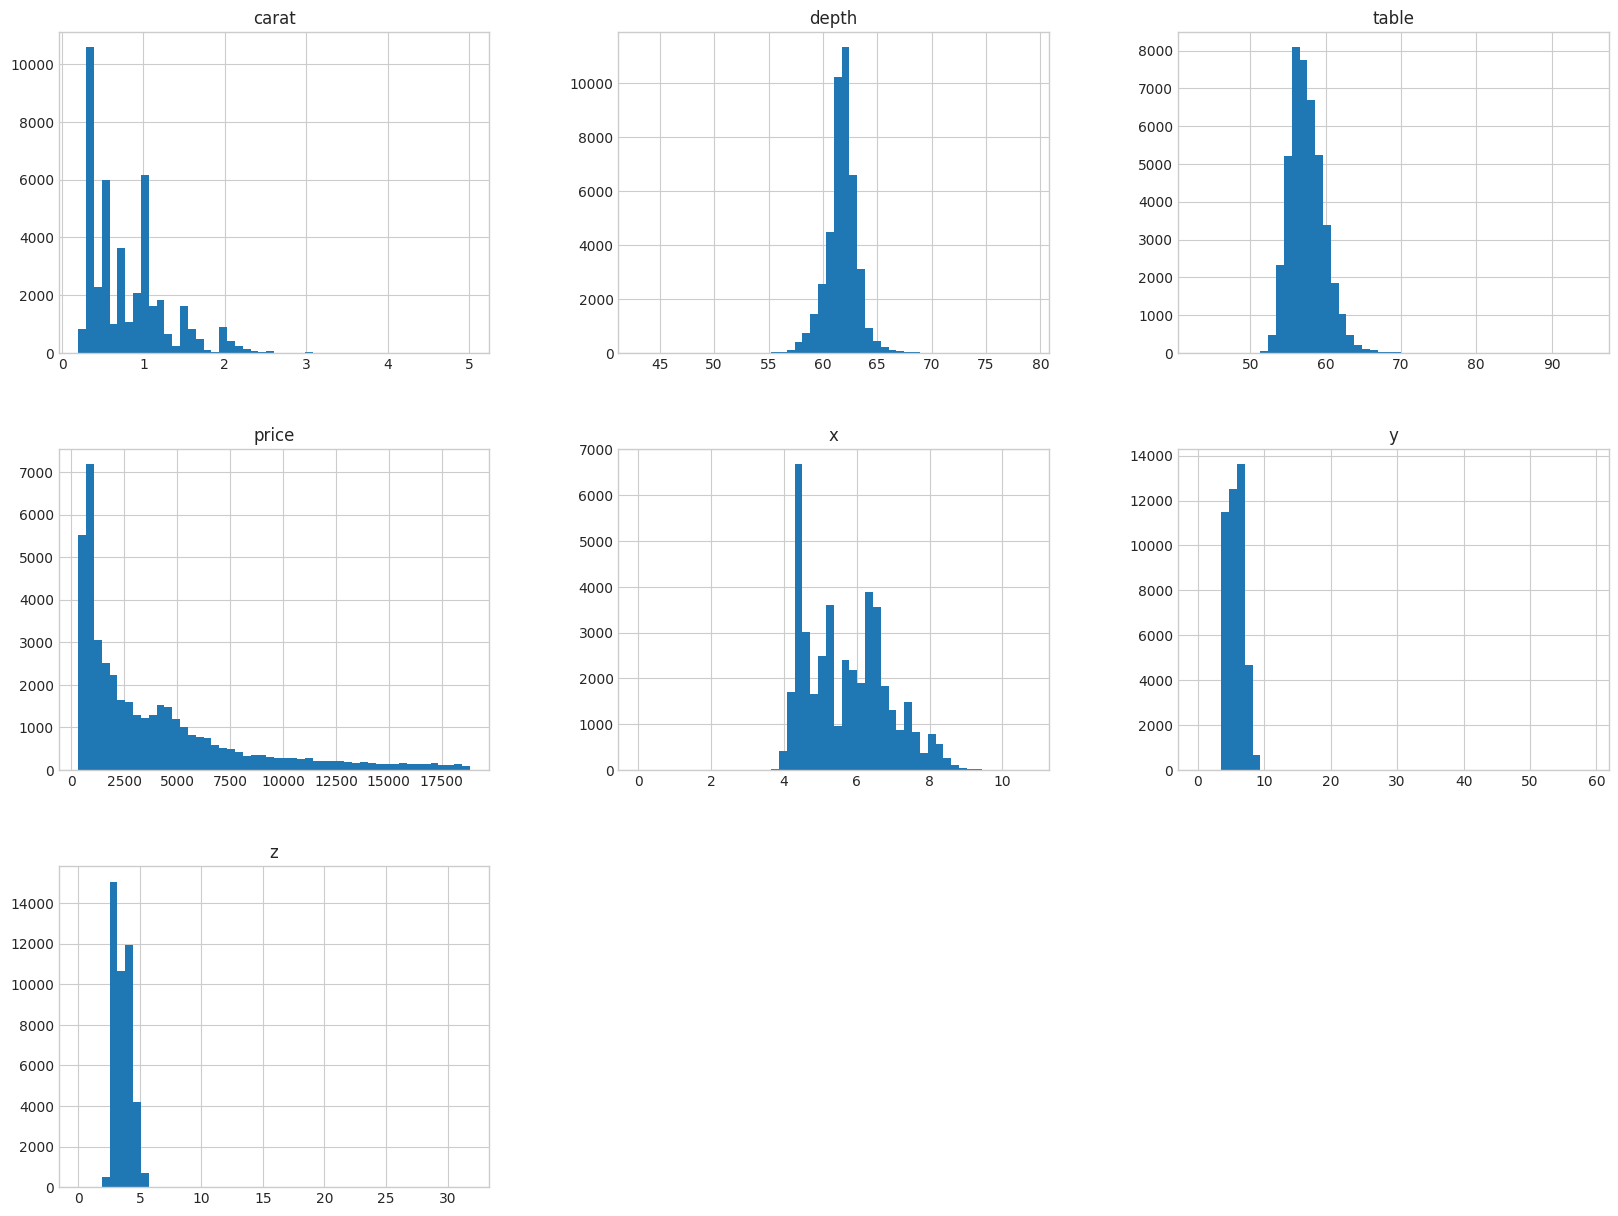

In [6]:
df.hist(bins=50, figsize=(20,15));

In [7]:
df.corr()['price'].sort_values(ascending=False)

price    1.000000
carat    0.923801
x        0.887483
y        0.863748
z        0.860625
table    0.136975
depth   -0.014393
Name: price, dtype: float64

# making functions and the pipeline workflow

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
class clean_outliers_and_divide_data ():
    
    def clean_outliers (self,X):
        for col in ['x', 'y', 'z']:
            X = X.mask(X[col] < 1).dropna(how='all')

        for col in X._get_numeric_data().columns:
            X =X.mask(X[col].isin(X[col].nlargest(10))).dropna(how='all')
            
        X = X.reset_index(drop=True)
        return X
    def divide_data (self,X):
        data_labels = X['price']
        X = X.drop('price',axis=1) # copy for enhancement
        return data_labels, X
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, volume = True): # no *args or **kargs
        self.volume = volume
    
    def fit(self, X, y=None):
         return self 
    def __iter__(self):
        for key,value in self.__dict__.items():
            if value == True :
                yield key, getattr(self, key)
            else :
                return self
    def transform(self, X):
        
        if self.volume :
            volume =X['carat']*0.2/3.51
            
            return np.c_[X, volume]
        else:
            return np.c_[X]

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
 ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
     ])

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
c1 = clean_outliers_and_divide_data()
df_pre =c1.clean_outliers(df)
data_labels , data_divided = c1.divide_data(df_pre)
num_attribs = list(data_divided._get_numeric_data().columns)
cat_attribs = ['cut','color','clarity']
t1= CombinedAttributesAdder()
extra_attribs = list(dict(t1).keys())
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OrdinalEncoder(), cat_attribs),
 ])

data_trans = full_pipeline.fit_transform(data_divided)
extra_attribs

['volume']

In [11]:
new_columns = num_attribs+extra_attribs+cat_attribs
new_columns

['carat', 'depth', 'table', 'x', 'y', 'z', 'volume', 'cut', 'color', 'clarity']

In [12]:
data_labels

0         326.0
1         334.0
2         335.0
3         336.0
4         336.0
          ...  
42944    2757.0
42945    2757.0
42946    2757.0
42947    2757.0
42948    2757.0
Name: price, Length: 42949, dtype: float64

In [13]:
data_prepared = pd.DataFrame(data_trans,columns=new_columns,index=data_divided.index)
data_prepared

,carat,depth,table,x,y,z,volume,cut,color,clarity
0,-1.229476,-1.370747,1.608884,-1.628106,-1.686200,-1.761168,-1.229476,3.0,1.0,2.0
1,-1.061088,0.463241,0.255670,-1.352435,-1.336922,-1.300102,-1.061088,3.0,5.0,5.0
2,-1.018991,1.098083,0.255670,-1.227938,-1.229452,-1.127202,-1.018991,1.0,6.0,3.0
3,-1.166331,0.745393,-0.195401,-1.583643,-1.578730,-1.516226,-1.166331,4.0,6.0,7.0
4,-1.166331,0.392703,-0.195401,-1.574750,-1.560818,-1.530635,-1.166331,4.0,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...
42944,-0.156000,0.674855,0.706742,-0.027434,0.006453,0.068686,-0.156000,3.0,0.0,2.0
42945,-0.156000,-0.665367,-0.195401,0.025921,0.033320,-0.046580,-0.156000,2.0,0.0,2.0
42946,-0.156000,0.957007,-1.097543,-0.027434,0.024365,0.111911,-0.156000,1.0,0.0,2.0
42947,0.138680,-0.524291,0.255670,0.381626,0.355730,0.299219,0.138680,3.0,4.0,3.0


# First baseline model using LinearRegression 

In [14]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(data_trans, data_labels)

LinearRegression()

# Evaluating the model

In [15]:
 from sklearn.metrics import mean_squared_error
data_predictions = lin_reg.predict(data_trans)
lin_mse = mean_squared_error(data_labels, data_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1298.6107908929991

In [16]:
print (f'Train Accuracy - : {lin_reg.score(data_trans,data_labels):.3f}')

Train Accuracy - : 0.895


In [17]:
from sklearn.model_selection import cross_val_score
scores_lin = cross_val_score(lin_reg, data_trans, data_labels,
 scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores_lin)

In [18]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)


Scores: [ 956.9243381  1075.09842666 1192.29301516 1759.62863522 2797.23050096
 1839.06738621  771.02539673  708.87125754  607.48819907  723.55485056]
Mean: 1243.1182006212248
Standard deviation: 658.1935322582996


# Forecasting using DecisionTree

In [19]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_trans, data_labels)

DecisionTreeRegressor()

In [20]:
data1_predictions = tree_reg.predict(data_trans)
tree_mse = mean_squared_error(data_labels, data1_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

9.560816395500474

In [21]:
print (f'Train Accuracy - : {tree_reg.score(data_trans,data_labels):.3f}')

Train Accuracy - : 1.000


In [22]:
scores_tree = cross_val_score(tree_reg, data_trans, data_labels,
 scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores_tree)
display_scores(tree_rmse_scores)

Scores: [ 673.04872836  793.90949592 1032.5970762  1629.21724208 3211.53930111
 1388.00073006  160.13243773  267.42423622  348.24565931  479.34836925]
Mean: 998.3463276253431
Standard deviation: 867.5066138422407


# Now using RandomForest

In [23]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(max_depth=80, min_samples_leaf=4, n_estimators=56)
forest_reg.fit(data_trans, data_labels)

RandomForestRegressor(max_depth=80, min_samples_leaf=4, n_estimators=56)

In [24]:
data2_predictions = forest_reg.predict(data_trans)
forest_mse = mean_squared_error(data_labels, data2_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

377.1962867179107

In [25]:
print (f'Train Accuracy - : {forest_reg.score(data_trans,data_labels):.3f}')

Train Accuracy - : 0.991


In [26]:
scores_forest = cross_val_score(forest_reg, data_trans, data_labels,
 scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores_forest)
display_scores(forest_rmse_scores)

Scores: [ 493.17408361  555.23842915  758.67938    1188.51335426 2524.79901166
 1283.10210209  137.02211414  200.30877876  252.47037189  358.90096482]
Mean: 775.2208590387963
Standard deviation: 692.9939316806173


# Feature importance 

In [28]:
feature_importances = forest_reg.feature_importances_
sorted(zip(feature_importances, new_columns), reverse=True)

[(0.5918953036750297, 'y'),
 (0.2143714239671586, 'volume'),
 (0.08325762879156376, 'carat'),
 (0.0614331193877458, 'clarity'),
 (0.03326094096476476, 'color'),
 (0.0066120411282597075, 'x'),
 (0.0043574825242155175, 'z'),
 (0.002341457364500264, 'depth'),
 (0.0014362640244211977, 'table'),
 (0.0010343381723405551, 'cut')]